References:
https://www.youtube.com/watch?v=CbTU92pbDKw
https://arxiv.org/pdf/2203.12105

In [2]:
from helpers import *
from preprocessor import *

%load_ext tensorboard
# Load the MIDI file
df = midi_get_df('classical-piano-type0_chpn-p19.mid')
df.head()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


,note,start_time,end_time,duration
0,70,0.000000,0.000000,0.000000
1,70,0.000000,0.015789,0.015789
2,39,0.000000,0.015789,0.015789
3,58,0.015789,0.041959,0.026170
4,55,0.015789,0.041959,0.026170


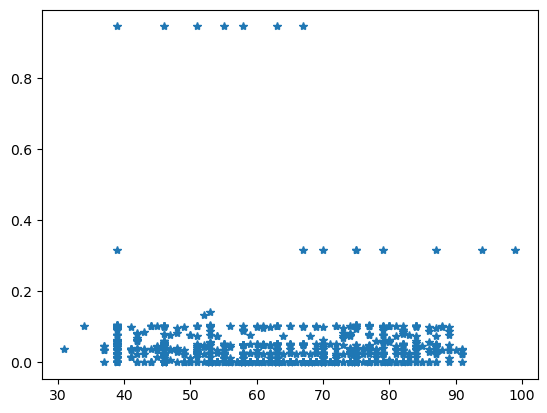

In [3]:
import matplotlib.pyplot as plt

plt.plot(df['note'], df['duration'], "*")

In [4]:
df = df[['start_time', 'note', 'duration']]
# df.index = df.pop('start_time') # set date as the index instead of numbering
df

,start_time,note,duration
0,0.000000,70,0.000000
1,0.000000,70,0.015789
2,0.000000,39,0.015789
3,0.015789,58,0.026170
4,0.015789,55,0.026170
...,...,...,...
1232,17.447794,55,0.944733
1233,17.447794,58,0.944733
1234,17.447794,51,0.944733
1235,17.447794,46,0.944733


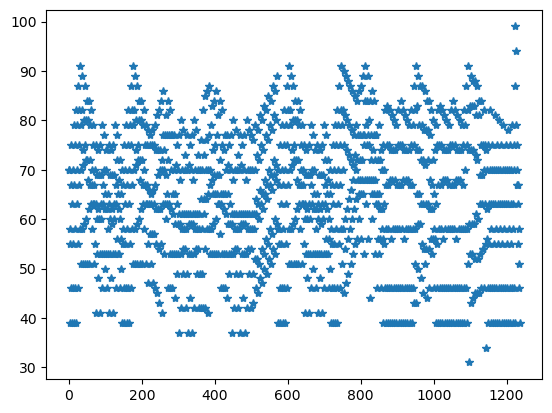

In [5]:
import matplotlib.pyplot as plt
plt.plot(df["note"], "*")

In [6]:
windowed_df = prepare_note_duration_data(df)
windowed_df

# target 1-3 are previous n values. This converts the inputs to the target output.

,start_time,duration_1,duration_2,duration_3,note_1,note_2,note_3,target_duration,target_note
0,0.000000,0.000000,0.015789,0.015789,70,70,39,0.026170,58
1,0.000000,0.015789,0.015789,0.026170,70,39,58,0.026170,55
2,0.000000,0.015789,0.026170,0.026170,39,58,55,0.052195,67
3,0.015789,0.026170,0.026170,0.052195,58,55,67,0.052195,46
4,0.015789,0.026170,0.052195,0.052195,55,67,46,0.104390,75
...,...,...,...,...,...,...,...,...,...
1228,16.503061,0.314911,0.314911,0.944733,70,75,63,0.944733,67
1229,16.503061,0.314911,0.944733,0.944733,75,63,67,0.944733,55
1230,17.447794,0.944733,0.944733,0.944733,63,67,55,0.944733,58
1231,17.447794,0.944733,0.944733,0.944733,67,55,58,0.944733,51


In [7]:
# time, X, y = windowed_df_to_date_X_y(windowed_df)
time = windowed_df["start_time"]
X = windowed_df[["duration_1", "note_1",
                "duration_2", "note_2",
                "duration_3", "note_3"]].to_numpy(dtype=np.float32)
X = X.reshape((X.shape[0], 3, 2))

y = windowed_df[["target_duration", "target_note"]]

time.shape, X.shape, y.shape

((1233,), (1233, 3, 2), (1233, 2))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, time_train, time_val = train_test_split(
    X, y, time, test_size=0.2, shuffle=False
)

In [9]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from keras.callbacks import EarlyStopping
import tensorflow as tf


# --- Define model ---
# model = Sequential([
#     layers.Input(shape=(3, 2)),
#     layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
#     layers.Bidirectional(layers.LSTM(64)),
#     layers.BatchNormalization(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(2)
# ])

model = Sequential([
  layers.Input(shape=(3, 2)),
  layers.LSTM(512, return_sequences=True),
  layers.LSTM(512, return_sequences=True),
  layers.LSTM(512),
  layers.Dropout(0.3),
  layers.BatchNormalization(),
  layers.Dense(256),
  layers.Dropout(0.3),
  layers.Dense(128),
  layers.Dropout(0.3),
  layers.Activation(activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(2)
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae']
)

# --- Early stopping ---
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

log_dir = "logs/fit/0.0001-300epoch" #+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# --- Train ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    # callbacks=[early_stop]
    callbacks=[tensorboard_callback]
)


2025-08-10 21:02:03.375239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 32.0165 - mae: 32.4664 - val_loss: 30.3518 - val_mae: 30.8244
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 31.7748 - mae: 32.2186 - val_loss: 29.3734 - val_mae: 29.6532
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 31.2101 - mae: 31.6391 - val_loss: 28.0077 - val_mae: 28.3588
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 30.5791 - mae: 31.0081 - val_loss: 26.5603 - val_mae: 26.9964
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 29.2232 - mae: 29.6362 - val_loss: 24.6303 - val_mae: 25.0669
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 27.7350 - mae: 28.1450 - val_loss: 23.0213 - val_mae: 23.4803
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 25.7593 - mae: 26.1590 - val_loss: 20.6455 - val_mae: 21.0776
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 23.6367 - mae: 24.0289 - val_loss: 17.5439 - val_mae: 17.9605
Epoch 9/100
31/

In [10]:
# --- Evaluate ---
loss, mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, MAE: {mae:.4f}")

# --- Predict ---
preds = model.predict(X_val)
print("Sample predictions:", preds[:5])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4742 - mae: 2.7202
Validation Loss: 2.8993, MAE: 3.1449
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Sample predictions: [[1.8105406e-02 6.7928322e+01]
 [2.1018971e-02 6.3357479e+01]
 [2.0323280e-02 7.3316910e+01]
 [3.3340055e-02 4.9611858e+01]
 [6.6473886e-02 8.1518196e+01]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


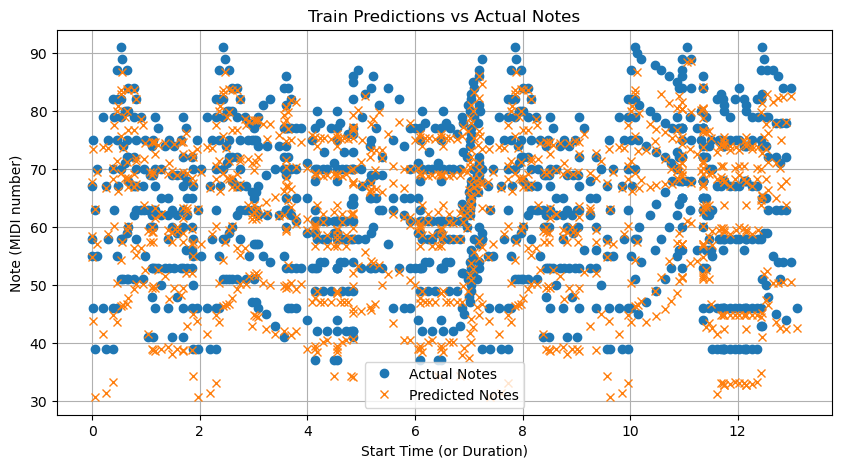

In [11]:
# --- Predict on train set ---
train_preds = model.predict(X_train)


# Plot train predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(time_train, y_train["target_note"], 'o', label='Actual Notes')
plt.plot(time_train, train_preds[:,1], 'x', label='Predicted Notes')
plt.xlabel('Start Time (or Duration)')
plt.ylabel('Note (MIDI number)')
plt.title('Train Predictions vs Actual Notes')
plt.legend()
plt.grid(True)
plt.show()

Recall that we use a prev 3 day to predict current point. This is characteristics of a lagging controller. This is shown in the plots where the predictions lag behind the actual value. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

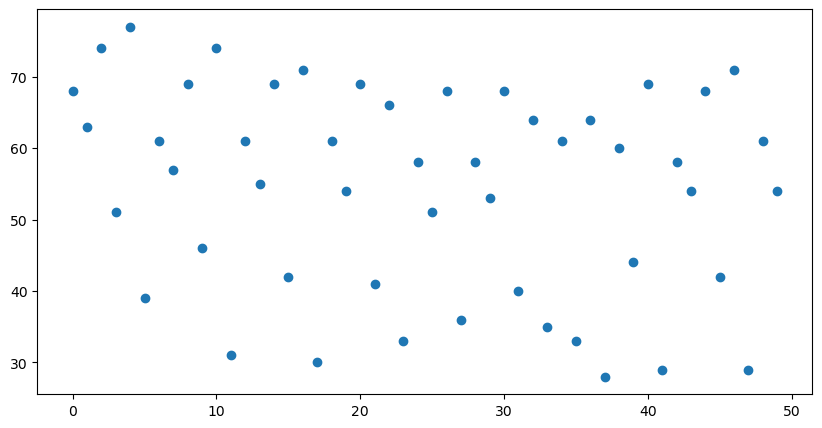

In [12]:
from sequential import *
# Usage:
initial_input = X_val[0]  # Example initial window from validation set
predicted_sequence = sequential_predict(model, initial_input, pred_steps=50)

plt.figure(figsize=(10, 5))

plt.plot(predicted_sequence[:,1], 'o', label='predicted sequence')